In [1]:
# imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# load data
pd.set_option('display.max_rows', 10000) 
pd.set_option('display.max_columns', 1000)
df = pd.read_excel('~/nfl_dashboard/ml_models/data/wr_data.xlsx')
df.drop(['Clean_Name','NFL_POS','DR','G_Y2','G_Y3','Y1_PPR_Pts','Pts_Y2','Pts_Y3','Y1-Y3_Total_PPR','G_Y1-Y3','Y1-Y3_PPR_PPG'], axis=1, inplace=True)
df.sort_values(by='Draft_Year', ascending=False, inplace=True, ignore_index=True)

# split data
labels_all = df.iloc[:, 0:5]
x_all = df.iloc[:, 5:-2] # all features
y_all = df.iloc[:, -1:] # all y data
train_x = df.iloc[22:, 5:-2] # features with at least 3 nfl years
train_y = df.iloc[22:, -1:] # y data with at least 3 nfl years

In [3]:
df.head()

,Name,School,Conference,Draft_Year,Landing_Team,DP,Age_In_Draft_Yr,BOA_20%,BOA_30%,Career_YPR,Career_REC/g,Career_College_Dominator_Rating,Career_Weighted_Dominator,Career_YPTpA_Dominator,Career_Yards_Dominator,First_RecYds/TmPatt,Best_RecYds/TmPatt,Last_RecYds/TmPatt,AVG_RecYds/TmPatt,First_RecYds/TmPatt_Above_Conference_AVg,Best_RecYds/TmPatt_Above_Conference_Avg,Last__RecYds/TmPatt_Above_Conference_Avg,AVG__RecYds/TmPatt_Above_Conference_Avg,First_RecYds/TmPatt_Above_AGE_Avg,Best_RecYds/TmPatt_Above_AGE_Avg,Last__RecYds/TmPatt_Above_AGE_Avg,AVG__RecYds/TmPatt_Above_AGE_Avg,First_RecYds/TmPatt_Above_Experience_Avg,Best_RecYds/TmPatt_Above_Experience_Avg,Last__RecYds/TmPatt_Above_Experience_Avg,AVG__RecYds/TmPatt_Above_Experience_Avg,First_RecYds/TmPatt_Above_Experience_Avg.1,Best_RecYds/TmPatt_Above_Experience_Avg.1,Last__RecYds/TmPatt_Above_Experience_Avg.1,AVG__RecYds/TmPatt_Above_Experience_Avg.1,First_Dominator,Best_Dominator,Last_Dominator,AVG_Dominator_(Min_2_Seasons),First_Dominator.1,Best_Dominator.1,Last_Dominator.1,AVG_Dominator_(Min_2_Seasons).1,First_Doa,Last_Doa,Best_Doa,Doa_(AVG),First_MS_rec_Yards,last_ms_rec_yards,Best_MS_rec_Yards,AVG_MS_REC_Yds,First_MS_TDs,Last_MS_TDs,Best_MS_TDs,AVG_MS_TDs,TeamMate_Score,Career_RecYd/GP,Career_RecTd/GP,Best_MS_RECs_(>=6_Gms),Last_MS_RECs_(>=6_Gms),Avg_MS_RECs_(>=6_Gms),Best_MS_REC_Yards_(for_AVG_if_played_more_then_6_games),Last_MS_REC_Yards_(for_AVG_if_played_more_then_6_games),Avg_MS_REC_Yards_(for_AVG_if_played_more_then_6_games),Best_MS_Yards_above/below_Average_by_age_(top_24_players),Last_MS_Yards_above/below_Average_by_age_(top_24_players),Avg_MS_Yards_above/below_Average_by_age_(top_24_players),Best_Player_Above/Below_AVG_Conference_REC_Yds_MS_>6_games,Last_Player_Above/Below_AVG_Conference_REC_Yds_MS_>6_games,Avg_Player_Above/Below_AVG_Conference_REC_Yds_MS_>6_games,Best_Player_Above/Below_AVG_Team_REC_Yds_MS,Last_Player_Above/Below_AVG_Team_REC_Yds_MS,Avg_Player_Above/Below_AVG_Team_REC_Yds_MS,Best_YTMpA_(Rec_Yards_Per_Team_Pass_Attempt)_>6_games,Last_YTMpA_(Rec_Yards_Per_Team_Pass_Attempt)_>6_games,Avg_YTMpA_(Rec_Yards_Per_Team_Pass_Attempt)_>6_games,Best_Team_Adjusted_YTMpA,Last_Team_Adjusted_YTMpA,Avg_Team_Adjusted_YTMpA,Best_Experience_Adjusted_YTMpA,Last_Experience_Adjusted_YTMpA,Avg_Experience_Adjusted_YTMpA,BMI,weight,height,bench,3Cone,shuttle,vert,broadInches,Burst_Score,HaSS,WaSS,Adjusted_40_Time,G_Y1,Y1_PPR_PPG
0,Jayden Reed,Michigan State,Big Ten (East),2023,NaN,167,22.0,18.0,18.0,15.067568,4.625000,0.518508,0.487391,2.571429,0.311098,2.202594,2.571429,2.571429,2.151947,0.274091,0.602738,0.602738,0.189569,0.594896,0.594896,0.004845,-0.04932,0.594719,0.367832,0.594719,0.238443,-0.028191,0.746863,0.746863,0.191975,0.356559,0.356559,0.340734,0.318456,0.329132,0.340734,0.340734,0.309313,0.134972,0.030209,0.134972,0.08259,0.258263,0.311098,0.311098,0.28468,0.400000,0.370370,0.400000,0.347699,0.019802,69.687500,0.656250,0.250000,0.242798,0.211885,0.311098,0.311098,0.284680,0.046294,-0.000050,0.023122,0.041425,0.007747,0.024586,0.054473,0.028813,0.041643,2.571429,2.571429,2.151947,0.768548,0.768548,-0.064833,-1.012979,-2.212744,-1.965316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Josh Downs,North Carolina,ACC (Coastal),2023,NaN,35,22.0,20.0,20.0,13.462963,6.352941,0.531988,0.574257,3.531746,0.401625,3.531746,3.531746,3.531746,3.531746,1.704642,1.704642,1.704642,NaN,1.102227,1.102227,1.102227,NaN,1.652028,1.652028,1.652028,NaN,-1.549014,0.982732,0.982732,-0.283141,0.194512,0.354658,0.354658,0.274585,0.354658,0.354658,0.354658,NaN,0.047224,0.047224,0.047224,NaN,0.401625,0.401625,0.401625,NaN,0.307692,0.307692,0.307692,NaN,NaN,85.529412,0.647059,0.426160,0.426160,0.426160,0.401625,0.401625,0.401625,0.100257,0.100257,0.100257,0.187639,0.187639,0.187639,0.205043,0.205043,0.205043,3.531746,3.531746,3.531746,1.168419,1.168419,1.168419,-0.770973,-0.770973,-0.770973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Marcus Rosemy,Georgia,SEC (E

In [4]:
# if played under 4 games in Y1 and scored over 5 ppg, drop data from training set
df_t = train_x.join(train_y).join(df.iloc[22:,-2:-1])
df_t = df_t.drop(df_t[(df_t['G_Y1'] < 4) & (df_t['Y1_PPR_PPG'] > 5)].index)
train_x, train_y= df_t.iloc[:,:-2], df_t.iloc[:,-2:-1]

In [5]:
# remove highly collinear features, keeping the feature w/strongest correlation to y-var
corr_thres = .70
drop_cntr = i = j_flag = i_flag = 0

while i < len(train_x.columns):
    j = i+1
    while j < len(train_x.columns):
        if (abs(train_x[train_x.columns[i]].corr(train_x[train_x.columns[j]])) > corr_thres):
            if abs(train_x[train_x.columns[i]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64'))) <= abs(train_x[train_x.columns[j]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64'))):
                print("deleted:", train_x.columns[i], " {0:.2f}%".format(train_x[train_x.columns[i]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64'))*100),
                      "\nkept:\t", train_x.columns[j], " {0:.2f}%".format(train_x[train_x.columns[j]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64'))*100),"\n");
                train_x = train_x.drop(train_x.columns[i], axis=1)
                x_all = x_all.drop(x_all.columns[i], axis=1)
                drop_cntr += 1
                i_flag = 1
                break
            else:
                print("deleted:", train_x.columns[j], " {0:.2f}%".format(train_x[train_x.columns[j]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64'))*100),
                      "\nkept:\t", train_x.columns[i], " {0:.2f}%".format(train_x[train_x.columns[i]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64'))*100),"\n");
                train_x = train_x.drop(train_x.columns[j], axis=1)
                x_all = x_all.drop(x_all.columns[j], axis=1)
                drop_cntr += 1
                j_flag = 1
        if j_flag == 0:
            j += 1
        j_flag = 0
    if i_flag == 0:
        i += 1
    i_flag = 0
                                                                                            
print('\033[1m' + '> ' + str(drop_cntr) + ' features were deleted.' + '\033[0m')
print('\033[1m' + '> ' + str(len(train_x.columns)) + ' features remain.' + '\033[0m')

deleted: BOA_30%  -20.43% 
kept:	 BOA_20%  -22.93% 

deleted: Career_REC/g  27.91% 
kept:	 AVG__RecYds/TmPatt_Above_AGE_Avg  42.60% 

deleted: Career_College_Dominator_Rating  20.45% 
kept:	 Career_Weighted_Dominator  22.16% 

deleted: Career_Weighted_Dominator  22.16% 
kept:	 Career_Yards_Dominator  22.61% 

deleted: Best_RecYds/TmPatt  32.25% 
kept:	 Career_YPTpA_Dominator  33.16% 

deleted: Last_RecYds/TmPatt  32.98% 
kept:	 Career_YPTpA_Dominator  33.16% 

deleted: Career_YPTpA_Dominator  33.16% 
kept:	 AVG_RecYds/TmPatt  33.39% 

deleted: Career_Yards_Dominator  22.61% 
kept:	 AVG_RecYds/TmPatt  33.39% 

deleted: First_RecYds/TmPatt_Above_Conference_AVg  14.86% 
kept:	 First_RecYds/TmPatt  17.76% 

deleted: First_RecYds/TmPatt  17.76% 
kept:	 AVG__RecYds/TmPatt_Above_Conference_Avg  32.76% 

deleted: Best_RecYds/TmPatt_Above_Conference_Avg  33.25% 
kept:	 AVG_RecYds/TmPatt  33.39% 

deleted: Last__RecYds/TmPatt_Above_Conference_Avg  33.33% 
kept:	 AVG_RecYds/TmPatt  33.39% 

delet

In [6]:
# #drop features with low correlation
# corr_threshold = .05
# cntr = i = 0

# while i < len(train_x.columns):
#     if(abs(train_x[train_x.columns[i]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64'))) < corr_threshold):
#         print(train_x.columns[i])
#         train_x = train_x.drop(train_x.columns[i], axis=1)
#         x_all = x_all.drop(x_all.columns[i], axis=1)
    
#         cntr += 1
#     else:
#         i += 1

# print('\033[1m' + '> ' + str(cntr) + ' features were deleted.' + '\033[0m')
# print('\033[1m' + '> ' + str(len(train_x.columns)) + ' features remain.' + '\033[0m')

In [7]:
train_x.isna().sum()

DP                                                             0
Age_In_Draft_Yr                                               15
BOA_20%                                                      200
Career_YPR                                                     0
AVG__RecYds/TmPatt_Above_AGE_Avg                              97
First_RecYds/TmPatt_Above_Experience_Avg.1                   145
Best_RecYds/TmPatt_Above_Experience_Avg.1                    145
Last_Dominator                                                 0
First_Doa                                                     20
First_MS_rec_Yards                                             5
AVG_MS_TDs                                                    47
TeamMate_Score                                                39
Career_RecTd/GP                                                0
Best_MS_RECs_(>=6_Gms)                                         0
Avg_Player_Above/Below_AVG_Conference_REC_Yds_MS_>6_games      0
Last_Player_Above/Below_A

In [8]:
# manual drops

list_to_drop = ['BMI','bench','3Cone','shuttle','vert','WaSS']
cntr = 0

for i in list_to_drop:
    x_all = x_all.drop(i, axis=1)
    train_x = train_x.drop(i, axis=1)
    cntr += 1


print('\033[1m' + '> ' + str(cntr) + ' features were deleted.' + '\033[0m')
print('\033[1m' + '> ' + str(len(x_all.columns)) + ' features remain.' + '\033[0m')

> 6 features were deleted.
> 18 features remain.


In [9]:
# print correlations
i = 0
while i < len(train_x.columns):
    corr = abs(train_x[train_x.columns[i]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64')))
    print(train_x.columns[i],": {0:.2f}%".format(corr*100),sep='')
    i += 1

DP: 65.04%
Age_In_Draft_Yr: 24.80%
BOA_20%: 22.93%
Career_YPR: 13.79%
AVG__RecYds/TmPatt_Above_AGE_Avg: 42.60%
First_RecYds/TmPatt_Above_Experience_Avg.1: 25.19%
Best_RecYds/TmPatt_Above_Experience_Avg.1: 37.85%
Last_Dominator: 27.74%
First_Doa: 20.93%
First_MS_rec_Yards: 18.90%
AVG_MS_TDs: 22.44%
TeamMate_Score: 2.77%
Career_RecTd/GP: 31.99%
Best_MS_RECs_(>=6_Gms): 17.09%
Avg_Player_Above/Below_AVG_Conference_REC_Yds_MS_>6_games: 19.64%
Last_Player_Above/Below_AVG_Team_REC_Yds_MS: 5.80%
Burst_Score: 12.90%
Adjusted_40_Time: 22.12%


<AxesSubplot:>

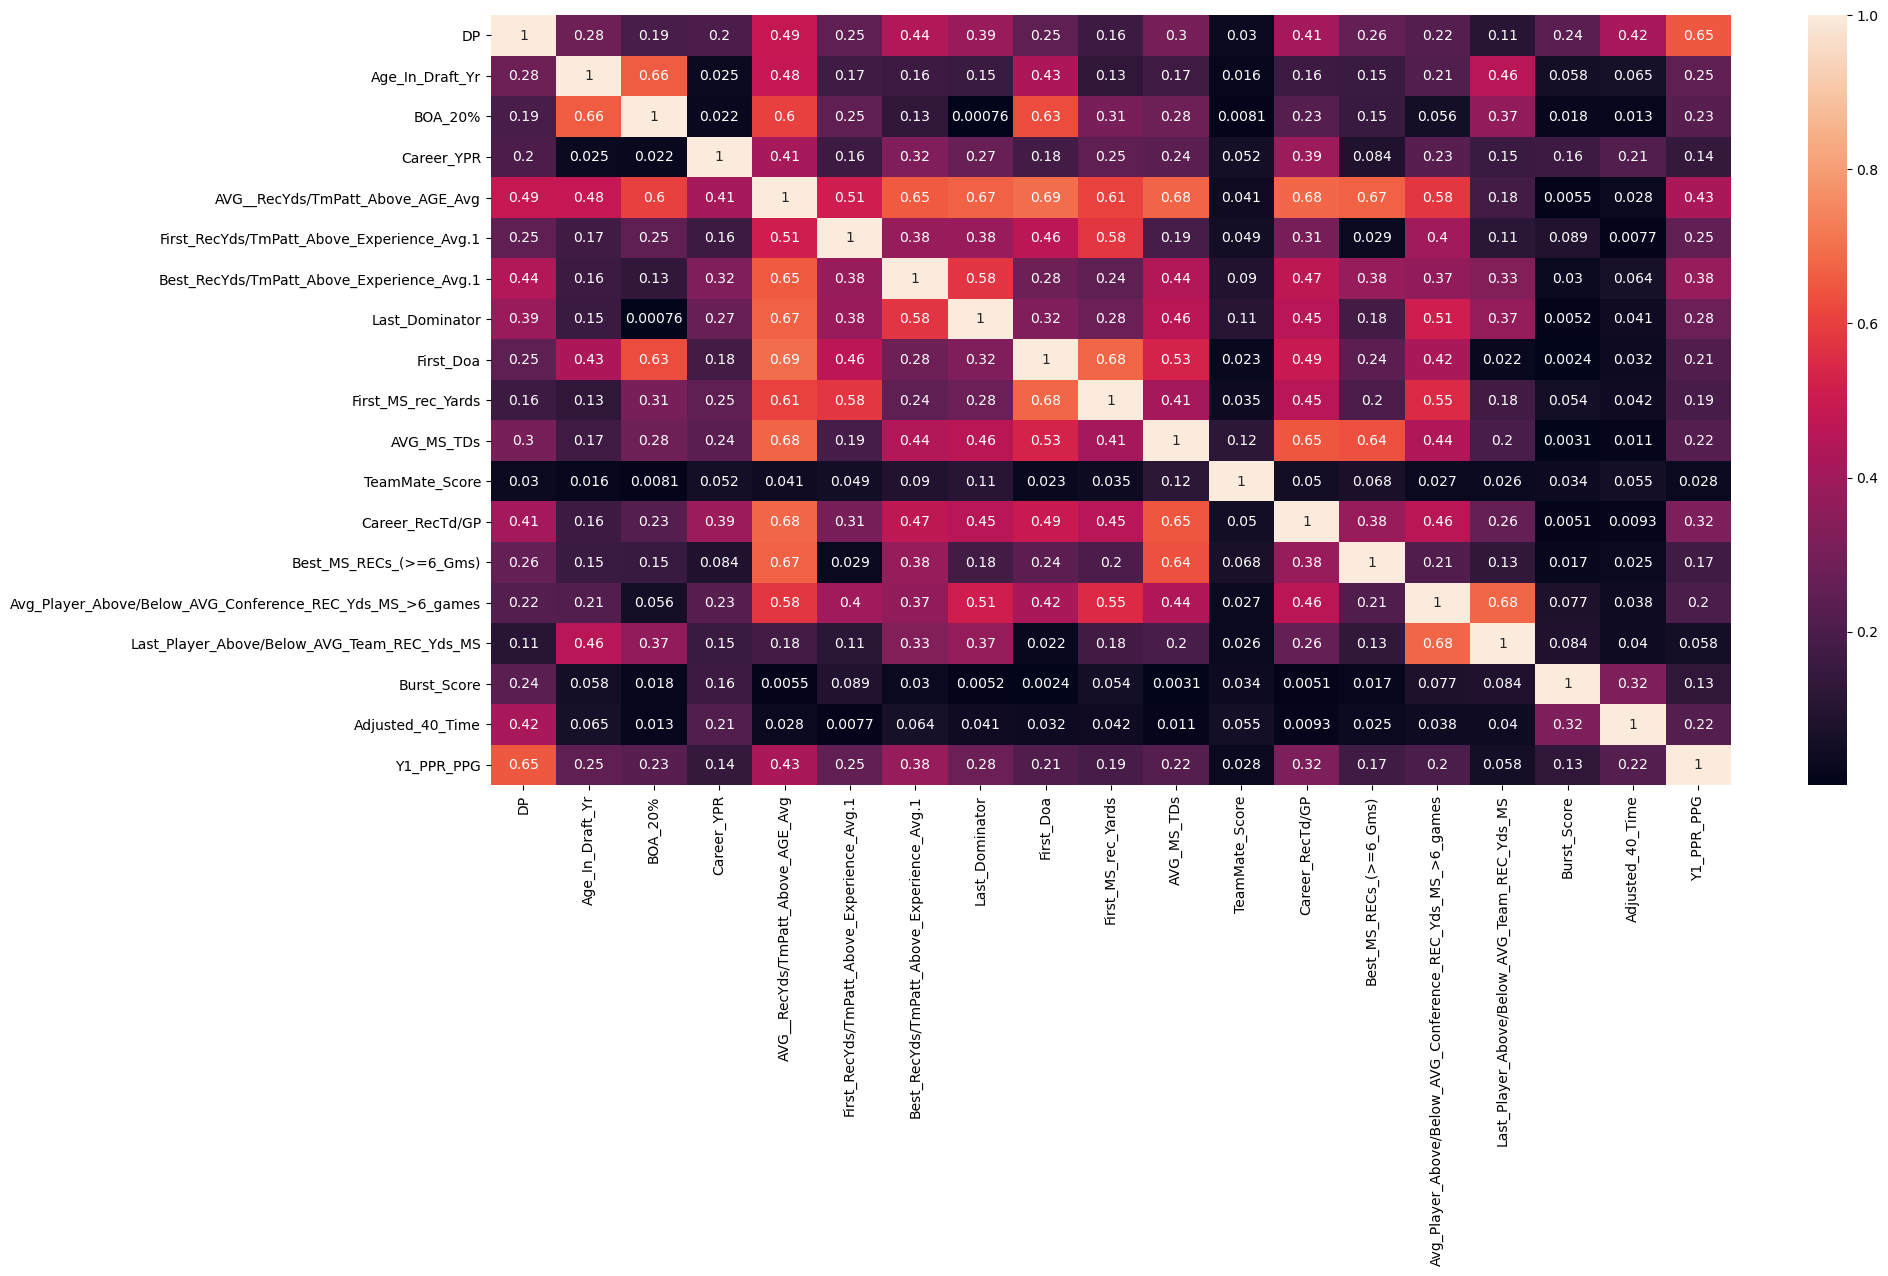

In [10]:
# Correlation Heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(abs(train_x.join(train_y).astype('float64').corr()), annot=True)

Text(0.5, 1.0, 'Distribution of NFL Total WR PPR PPG')

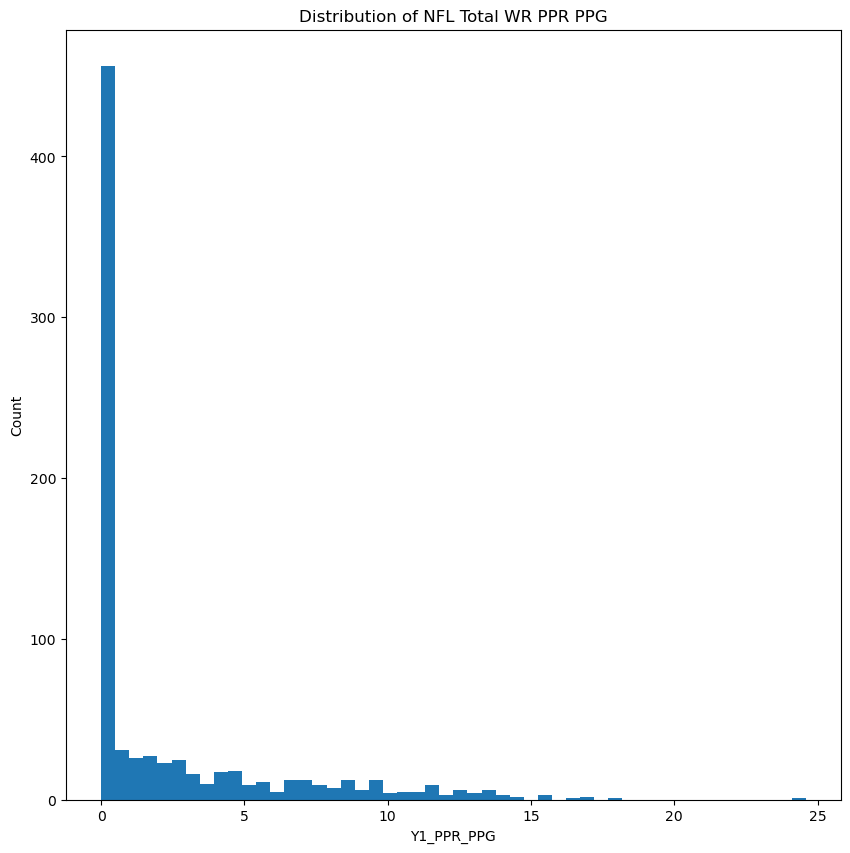

In [11]:
# Look at distribution of target variable -> very positibly skewed
plt.rcParams["figure.figsize"] = (10, 10)
plt.hist(train_y['Y1_PPR_PPG'], bins = 50)
plt.xlabel('Y1_PPR_PPG')
plt.ylabel('Count')
plt.title('Distribution of NFL Total WR PPR PPG')

In [12]:
len(train_x)

799

Len X_train: 599
Len X_test: 200


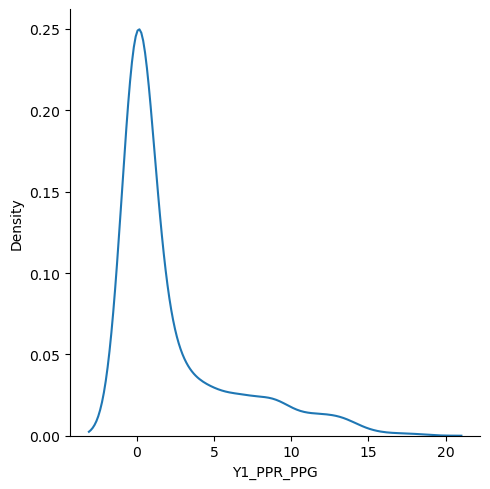

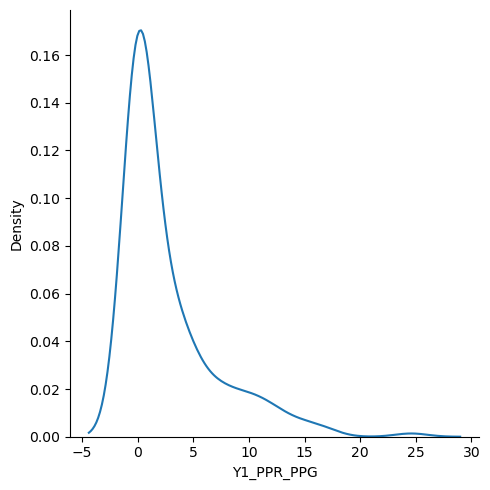

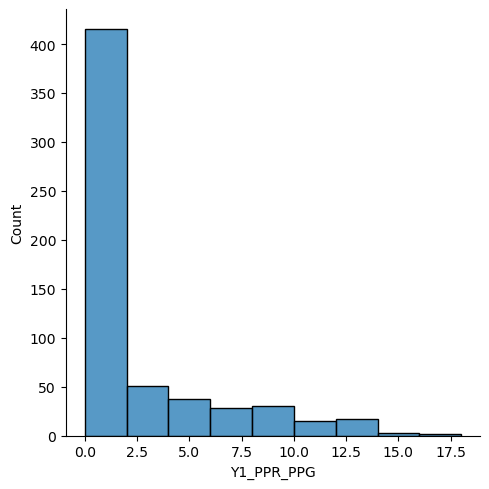

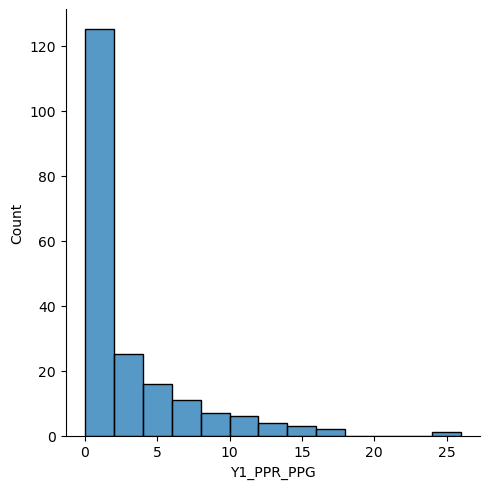

In [13]:
# stratified split of continous data
# Create the bins.  My `y` variable has
# 677 observations, and I want 50 bins.

bins = np.linspace(0, 799, 30)

# Save your Y values in a new ndarray,
# broken down by the bins created above.

y_binned = np.digitize(train_y, bins)

# Pass y_binned to the stratify argument,
# and sklearn will handle the rest

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.25, 
                                                    shuffle=True, stratify=y_binned, 
                                                    random_state=0)
print("Len X_train:", len(X_train))
print("Len X_test:", len(X_test))
sns.displot(y_train, x="Y1_PPR_PPG", kind="kde")
sns.displot(y_test, x="Y1_PPR_PPG", kind="kde")
sns.displot(y_train, x="Y1_PPR_PPG",binwidth=2)
sns.displot(y_test, x="Y1_PPR_PPG",binwidth=2)

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.reset_option('all')

In [15]:
import os
  
n_cpu = os.cpu_count()
print("Number of CPUs in the system:", n_cpu)

Number of CPUs in the system: 8


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

xgb_model = XGBRegressor(verbosity=0)
params = {'n_estimators': [150,200,300],
          'max_depth': [2,3],
          'learning_rate': [0.01,0.005],
          'gamma': [10],
          'subsample': [0.7,0.85,1],
          'colsample_bytree': [1],
          'base_score': [0]}
reg = GridSearchCV(estimator = xgb_model, 
             param_grid = params,
             scoring='neg_mean_absolute_error', 
             n_jobs=-1, 
             refit=True, 
             cv=4, 
             verbose=2)

reg.fit(train_x, train_y.astype('float64'))
print('done')

Fitting 4 folds for each of 36 candidates, totalling 144 fits


/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instea

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

done


In [17]:
reg.best_params_

{'base_score': 0,
 'colsample_bytree': 1,
 'gamma': 10,
 'learning_rate': 0.005,
 'max_depth': 2,
 'n_estimators': 300,
 'subsample': 0.7}

[0]	validation_0-mae:2.23461	validation_1-mae:2.64655
[1]	validation_0-mae:2.22378	validation_1-mae:2.63292
[2]	validation_0-mae:2.21207	validation_1-mae:2.61960
[3]	validation_0-mae:2.20131	validation_1-mae:2.60582
[4]	validation_0-mae:2.18894	validation_1-mae:2.59089
[5]	validation_0-mae:2.17724	validation_1-mae:2.57671
[6]	validation_0-mae:2.16697	validation_1-mae:2.56455
[7]	validation_0-mae:2.15630	validation_1-mae:2.55126
[8]	validation_0-mae:2.14622	validation_1-mae:2.53762
[9]	validation_0-mae:2.13493	validation_1-mae:2.52423
[10]	validation_0-mae:2.12464	validation_1-mae:2.51042
[11]	validation_0-mae:2.11565	validation_1-mae:2.49953
[12]	validation_0-mae:2.10739	validation_1-mae:2.48992
[13]	validation_0-mae:2.09881	validation_1-mae:2.47859
[14]	validation_0-mae:2.08983	validation_1-mae:2.46606
[15]	validation_0-mae:2.08052	validation_1-mae:2.45327
[16]	validation_0-mae:2.07064	validation_1-mae:2.44122
[17]	validation_0-mae:2.06039	validation_1-mae:2.42858
[18]	validation_0-ma

[149]	validation_0-mae:1.62631	validation_1-mae:1.88335
[150]	validation_0-mae:1.62634	validation_1-mae:1.88268
[151]	validation_0-mae:1.62655	validation_1-mae:1.88286
[152]	validation_0-mae:1.62602	validation_1-mae:1.88197
[153]	validation_0-mae:1.62538	validation_1-mae:1.88061
[154]	validation_0-mae:1.62466	validation_1-mae:1.87958
[155]	validation_0-mae:1.62409	validation_1-mae:1.87936
[156]	validation_0-mae:1.62368	validation_1-mae:1.87821
[157]	validation_0-mae:1.62242	validation_1-mae:1.87660
[158]	validation_0-mae:1.62228	validation_1-mae:1.87632
[159]	validation_0-mae:1.62187	validation_1-mae:1.87558
[160]	validation_0-mae:1.62140	validation_1-mae:1.87471
[161]	validation_0-mae:1.62072	validation_1-mae:1.87469
[162]	validation_0-mae:1.61977	validation_1-mae:1.87372
[163]	validation_0-mae:1.61916	validation_1-mae:1.87274
[164]	validation_0-mae:1.61793	validation_1-mae:1.87186
[165]	validation_0-mae:1.61776	validation_1-mae:1.87123
[166]	validation_0-mae:1.61697	validation_1-mae:

[296]	validation_0-mae:1.55758	validation_1-mae:1.82090
[297]	validation_0-mae:1.55765	validation_1-mae:1.82087
[298]	validation_0-mae:1.55741	validation_1-mae:1.82056
[299]	validation_0-mae:1.55694	validation_1-mae:1.82066
[300]	validation_0-mae:1.55690	validation_1-mae:1.82061
[301]	validation_0-mae:1.55615	validation_1-mae:1.81961
[302]	validation_0-mae:1.55549	validation_1-mae:1.81950
[303]	validation_0-mae:1.55550	validation_1-mae:1.81936
[304]	validation_0-mae:1.55486	validation_1-mae:1.81891
[305]	validation_0-mae:1.55446	validation_1-mae:1.81903
[306]	validation_0-mae:1.55437	validation_1-mae:1.81871
[307]	validation_0-mae:1.55469	validation_1-mae:1.81890
[308]	validation_0-mae:1.55428	validation_1-mae:1.81803
[309]	validation_0-mae:1.55380	validation_1-mae:1.81816
[310]	validation_0-mae:1.55321	validation_1-mae:1.81756
mae: 1.8175629064765135


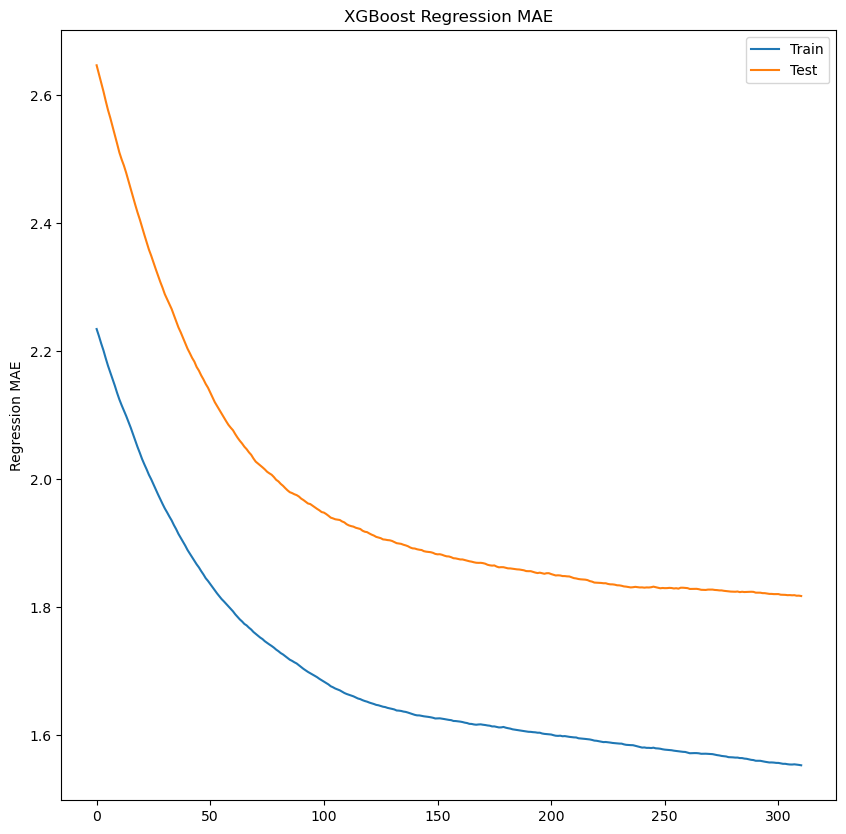

In [19]:
# from xgboost import XGBRegressor 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error

xgb_model = XGBRegressor(learning_rate=.01, 
                         gamma=10, 
                         n_estimators=311, 
                         max_depth=2, 
                         subsample=0.7, 
                         colsample_bytree=1, 
                         base_score=0)

eval_set = [(X_train, y_train.astype('float64')),(X_test, y_test.astype('float64'))]

xgb_model.fit(X_train, y_train, eval_metric='mae', eval_set=eval_set, verbose=True) 
#xgb_model.fit(X_train, y_train.astype('float64'), early_stopping_rounds=20, eval_metric='mae', eval_set=eval_set, verbose=True)

y_pred = xgb_model.predict(X_test) 
mae = mean_absolute_error(y_test.astype('float64'), y_pred) 
print("mae: " + str(mae))

from matplotlib import pyplot
#retrieve performance metrics
results = xgb_model.evals_result()
epochs = len(results['validation_0']['mae']) 
x_axis = range(0, epochs)
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
pyplot.ylabel('Regression MAE')
pyplot.title('XGBoost Regression MAE')
#pyplot.ylim(0,4.25)
pyplot.show()

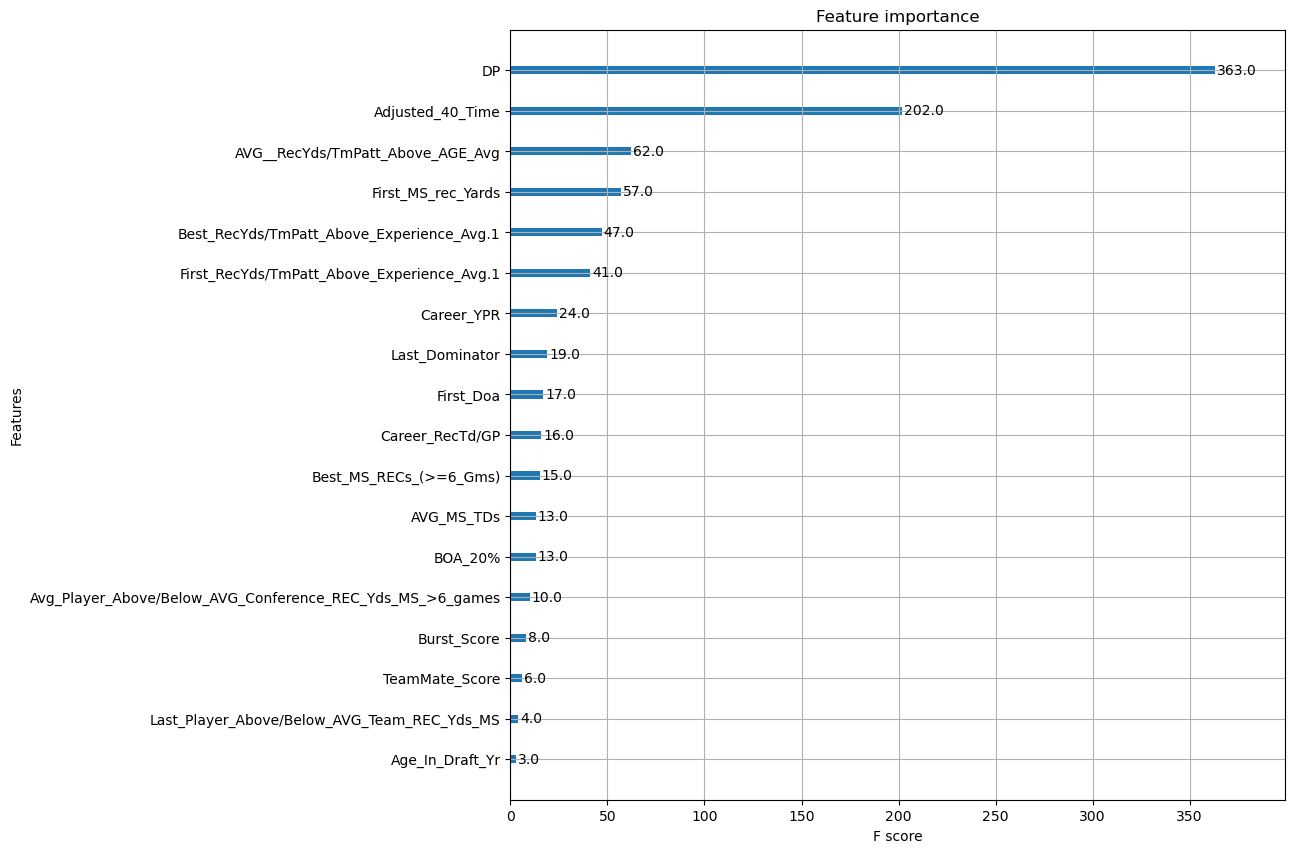

In [20]:
from xgboost import plot_importance
xgb_model.fit(train_x, train_y.astype('float64'))
plt.rcParams['figure.figsize'] = [10, 10]
plot_importance(xgb_model)
plt.show()

In [21]:
preds = pd.DataFrame(xgb_model.predict(x_all))

In [22]:
def red_background_2022(cell_value):
    highlight = 'background-color: red;'
    default = ''
    if cell_value == 2022:
        return highlight
    else:
        return default     

In [23]:
pd.set_option('display.max_rows', 10000) 
pd.set_option('display.max_columns', 1000)
results = labels_all.join(preds)
results = results.join(y_all)
#pd.set_option('precision', 3)
results = results.join(x_all.iloc[:,:1])
results.rename(columns={0:'Pred'}, inplace=True )
results['Percentile Rank'] = results.Pred.rank(pct = True)
results = results.sort_values(by=['Pred'], ascending=False).reset_index(drop=True)
results = results.sort_values(by=['Draft_Year','Pred'], ascending=False).reset_index(drop=True)
results.loc[:, "Pred"] = results["Pred"].map('{:.2f}'.format)
cm = sns.color_palette("inferno", as_cmap=True)
results.style.background_gradient(cmap=cm, subset='Pred').background_gradient(cmap=cm, subset='Y1-Y3_PPR_PPG').applymap(red_background_2022).set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector = 'th', props=[('text-align', 'center')])])
results.head(1000)

,Name,School,Conference,Draft_Year,Landing_Team,Pred,Y1_PPR_PPG,DP,Percentile Rank
0,Quentin Johnston,Texas Christian,Big 12,2023,NaN,6.99,NaN,10,0.909091
1,Jordan Addison,Pittsburgh,ACC (Coastal),2023,NaN,6.81,NaN,16,0.903030
2,Jaxon Smith-Njigba,Ohio State,Big Ten (East),2023,NaN,6.25,NaN,19,0.888485
3,Josh Downs,North Carolina,ACC (Coastal),2023,NaN,6.19,NaN,35,0.887273
4,Zay Flowers,Boston College,ACC (Atlantic),2023,NaN,5.65,NaN,40,0.867879
5,Kayshon Boutte,Louisiana State,SEC (West),2023,NaN,5.25,NaN,43,0.852121
6,Jalin Hyatt,Tennessee,SEC (East),2023,NaN,4.70,NaN,33,0.835152
7,Marvin Mims,Oklahoma,Big 12,2023,NaN,3.41,NaN,94,0.763636
8,Dontay Demus,Maryland,Big Ten (East),2023,NaN,1.54,NaN,138,0.646061
9,Jayden Reed,Michigan State,Big Ten (East),2023,NaN,1.33,NaN,167,0.620606


In [24]:
results.to_excel("~/Desktop/wr_y1_xgb.xlsx")  

In [25]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train.iloc[:,:1],y_train)
y_pred = lr_model.predict(X_test.iloc[:,:1])
mae = mean_absolute_error(y_test, y_pred)
print("MAE of Draft Pick Linear Regression: " + str(mae))

MAE of Draft Pick Linear Regression: 2.0251685004552864
